In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from timeit import timeit

from sklearn.model_selection import ParameterGrid

In [2]:
inp_data = pd.read_csv('zip_data/AUDCAD.csv', index_col=1)
inp_data.index = pd.to_datetime(inp_data.index)
#inp_data.resample('1T').first()
inp_data.drop(['instrument', 'volume', 'average', 'barCount'], axis=1, inplace=True)

inp_data

,open,high,low,close
time,,,,
2018-11-01 00:15:00,0.931100,0.931135,0.930670,0.931025
2018-11-01 00:16:00,0.931025,0.931100,0.930965,0.931065
2018-11-01 00:17:00,0.931065,0.931120,0.930935,0.931090
2018-11-01 00:18:00,0.931090,0.931250,0.931090,0.931145
2018-11-01 00:19:00,0.931145,0.931175,0.931115,0.931115
...,...,...,...,...
2021-11-13 00:55:00,0.919965,0.920050,0.919885,0.919965
2021-11-13 00:56:00,0.919965,0.920120,0.919885,0.920035
2021-11-13 00:57:00,0.920035,0.920035,0.919930,0.919935


In [3]:
# Нужно задать частоту данных для стабильности метода создания BBands
global DataFrequency

DataFrequency = '1T'

576
{'Capital': 100000, 'slippage': 10, 'slippagePerCap': 0.0001, 'window_rolling': '10T', 'Y_threshold': 10, 'max_hold_period': '6H', 'stopLossesPercent': {'BuyLossPercent': 0.02, 'SellLossPercent': 0.02}, 'takePercent': {'SellTakePercent': 0.004, 'BuyTakePercent': 0.004}, 'shift_param': 10, 'time_barrier_param': 360}


  0%|          | 0/490 [00:00<?, ?it/s]

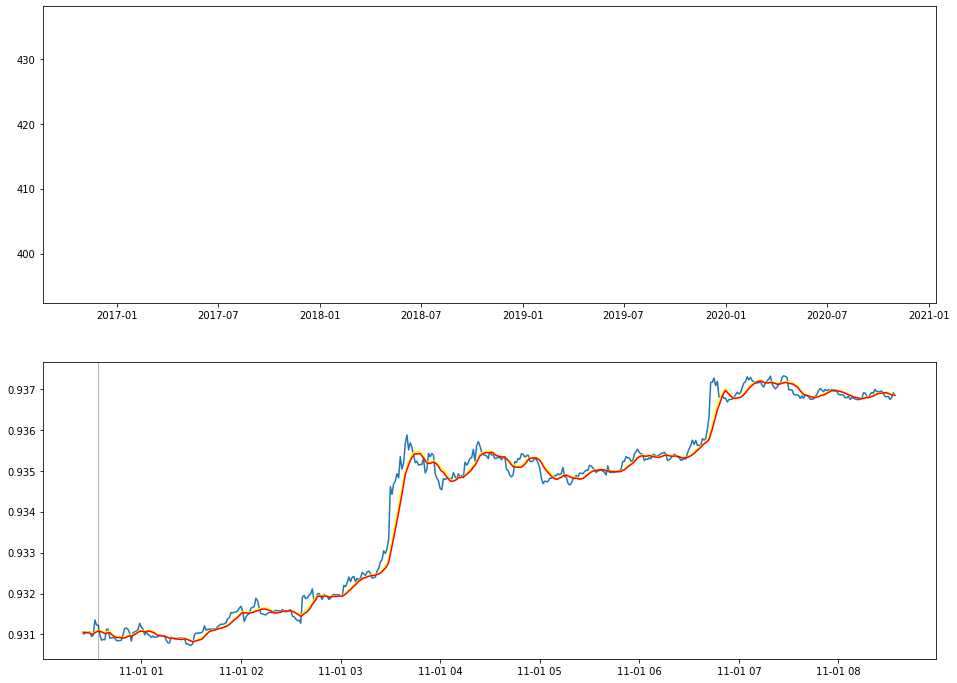

In [9]:
def OpenPosition(current_dot, arrow_index, Parameters_Dict):
    """
    Проверяет возможно ли открыть сделку. В случае возможности возвращает информацию об открытой сделки
    :param current_dot:
    :param arrow_index:
    :return:
    """
    # Задается вид словаря описывающего информацию об открытии сделки
    ret_dict = {'type_operation': None,
                'position': None,
                'open_price': None,
                'open_index': None,
                }
    # Проверка о пересечении нижней границы
    if current_dot.open < current_dot.LowBBand:
        ret_dict['type_operation'] = 'SELL'
        ret_dict['position'] = -1 * (Parameters_Dict['Capital'] / current_dot.open)
        ret_dict['open_price'] = current_dot.open
        ret_dict['open_index'] = arrow_index

    # Проверка о пересечении верхней границы
    if current_dot.open > current_dot.HighBBand:
        ret_dict['type_operation'] = 'BUY'
        ret_dict['position'] = (Parameters_Dict['Capital'] / current_dot.open)
        ret_dict['open_price'] = current_dot.open
        ret_dict['open_index'] = arrow_index

    return ret_dict

def StopLossStatus(current_dot, open_dict, Parameters_Dict):
    """
    Определяет логику исполнения StopLoss
    :param current_dot:
    :param open_dict:
    :param Parameters_Dict:
    :return:
    """
    if open_dict['type_operation'] == 'SELL':
        if (open_dict['open_price'] / current_dot.high) - 1 < -1 * (Parameters_Dict['stopLossesPercent']['SellLossPercent'] + Parameters_Dict['slippagePerCap']):
            return True, open_dict['open_price'] * (1 + Parameters_Dict['stopLossesPercent']['BuyLossPercent'] + Parameters_Dict['slippagePerCap']),
    if open_dict['type_operation'] == 'BUY':
        if (current_dot.low / open_dict['open_price']) - 1 < -1 * (Parameters_Dict['stopLossesPercent']['BuyLossPercent'] + Parameters_Dict['slippagePerCap']):
            return True, open_dict['open_price'] * (1 - Parameters_Dict['stopLossesPercent']['BuyLossPercent'] - Parameters_Dict['slippagePerCap'])

    return False, False

def TakeProfitStatus(current_dot, open_dict, Parameters_Dict):
    """
    Определяет логику исполнения TakeProfit
    :param current_dot:
    :param open_dict:
    :param Parameters_Dict:
    :return:
    """
    if open_dict['type_operation'] == 'SELL':
        if (open_dict['open_price'] / current_dot.high) - 1 > Parameters_Dict['takePercent']['SellTakePercent'] + Parameters_Dict['slippagePerCap']:
            return True, open_dict['open_price'] * (1 + Parameters_Dict['takePercent']['SellTakePercent'] + Parameters_Dict['slippagePerCap']),

    if open_dict['type_operation'] == 'BUY':
        if (current_dot.low / open_dict['open_price']) - 1 > Parameters_Dict['takePercent']['BuyTakePercent'] + Parameters_Dict['slippagePerCap']:
            return True, current_dot.low

    return False, False

def HoldingPosition(open_dict, potential_dataFrame, Parameters_Dict):
    """
    Определяет логику удержания позиции
    :param open_dict:
    :param potential_dataFrame:
    :param Parameters_Dict:
    :return:
    """
    # Определяется тип возврата
    ret_dict = {'type_holding':'endPeriod',
                'close_price': None,
                'close_index': None,
                }
    # Итерация по всем точкам в возможном для удержания дата батче
    for hold_index in potential_dataFrame.index:
        # Сначала проверяем stopLoss
        sLoss = StopLossStatus(current_dot=potential_dataFrame.loc[hold_index],
                            open_dict=open_dict, Parameters_Dict=Parameters_Dict)
        # В случае исполнения делаем запись и останавливаем цикл
        if sLoss[0]:
            ret_dict['type_holding'] = 'stopLoss'
            ret_dict['close_price'] =  sLoss[1]
            ret_dict['close_index'] = hold_index
            break
        # Проверяем takeProfit
        tProfit = TakeProfitStatus(current_dot=potential_dataFrame.loc[hold_index],
                                   open_dict=open_dict, Parameters_Dict=Parameters_Dict)
        # В случае исполнения делаем запись и останавливаем цикл
        if tProfit[0]:
            ret_dict['type_holding'] = 'takeProfit'
            ret_dict['close_price'] = tProfit[1]
            ret_dict['close_index'] = hold_index
            break

    if not ret_dict['close_index']:
        ret_dict['close_price'] = potential_dataFrame.iloc[-1].close
        ret_dict['close_index'] = potential_dataFrame.index[-1]

    return ret_dict


def calculate_profit(status_open, status_hold, Parameters_Dict):
    profit = None

    if status_hold['type_holding'] == 'endPeriod':
        if status_open['type_operation'] == 'BUY':
            profit = status_open['position'] * (status_hold['close_price'] - status_open['open_price']) - Parameters_Dict['slippage']
        if status_open['type_operation'] == 'SELL':
            profit = status_open['position'] * (status_open['open_price'] - status_hold['close_price']) - Parameters_Dict['slippage']


    if status_hold['type_holding'] == 'stopLoss':
        if status_open['type_operation'] == 'BUY':
            profit = status_open['position'] * (status_hold['close_price'] - status_open['open_price']) - Parameters_Dict['slippage']
        if status_open['type_operation'] == 'SELL':
            profit = status_open['position'] * (status_open['open_price'] - status_hold['close_price']) - Parameters_Dict['slippage']

    if status_hold['type_holding'] == 'takeProfit':
        if status_open['type_operation'] == 'BUY':
            profit = status_open['position'] * (status_hold['close_price'] - status_open['open_price']) - Parameters_Dict['slippage']
        if status_open['type_operation'] == 'SELL':
            profit = status_open['position'] * (status_open['open_price'] - status_hold['close_price']) - Parameters_Dict['slippage']

    own = status_hold['close_index'] - status_open['open_index']
    return profit, own

def processStrategy(data_frame, params_dict):
    for int_arrow, index in enumerate(data_frame.index):
        if (data_frame.loc[index - pd.Timedelta(params_dict['window_rolling']): index + pd.Timedelta(params_dict['max_hold_period'])].shape[0] == params_dict['shift_param'] + params_dict['time_barrier_param']):
            # print(data_frame.loc[index - pd.Timedelta(params_dict['window_rolling']): index + pd.Timedelta(params_dict['max_hold_period'])])
            open_status = OpenPosition(current_dot=data_frame.loc[index], arrow_index=index, Parameters_Dict=params_dict)
            # print('OPEN:', timeit(lambda: OpenPosition(current_dot=data_frame.loc[index], arrow_index=index, Parameters_Dict=params_dict), number=1))
            if open_status['type_operation']:
                holding = HoldingPosition(open_dict=open_status,
                                potential_dataFrame=data_frame.copy().iloc[int_arrow: int_arrow + params_dict['time_barrier_param'], :],
                                Parameters_Dict=params_dict)
                # print('HOLDING:', timeit(lambda: HoldingPosition(open_dict=open_status, potential_dataFrame=data_frame.copy().iloc[int_arrow: int_arrow + time_barrier_param, :], Parameters_Dict=params_dict), number=1))
                profit, owning_position = calculate_profit(status_open=open_status, status_hold=holding, Parameters_Dict=params_dict)
                # print('CALCULATE:', timeit(lambda: calculate_profit(status_open=open_status, status_hold=holding, Parameters_Dict=params_dict), number=1))
                df_line = {'Type': open_status["type_operation"],
                           'OpenTime': open_status["open_index"],
                           'Position': open_status["position"],
                           'CloseTime': holding["close_index"],
                           'HoldType': holding["type_holding"],
                           'Profit': profit,
                           'Markdown': owning_position}


                return df_line
    return None

def _estimator(data_frame, params_dict):
    # Считается параметр насколько нужно обрезать данные для адекватности сглаживания

    # Скользящее среднее
    data_frame.loc[:, 'rolling_mean'] = data_frame.loc[:, 'close'].rolling(params_dict['window_rolling']).mean()

    # Скользящее отклонение
    data_frame.loc[:, 'rolling_std'] = data_frame.loc[:, 'close'].rolling(params_dict['window_rolling']).std()

    # Отсечение данных имеющих
    data_frame.drop(data_frame.index[:params_dict['shift_param']], axis=0, inplace=True)

    # Верхний уровень BBand
    data_frame.loc[:, 'HighBBand'] = data_frame.loc[:, 'rolling_mean'] + ((params_dict['Y_threshold'] / 100) * data_frame.loc[:, 'rolling_std'])

    # Нижний уровень BBand
    data_frame.loc[:, 'LowBBand'] = data_frame.loc[:, 'rolling_mean'] - ((params_dict['Y_threshold'] / 100) * data_frame.loc[:, 'rolling_std'])

    # Добавление номера линии для удобства
    data_frame['line_number'] = range(1, data_frame.shape[0] + 1)

    close = data_frame.close
    hband = data_frame.HighBBand
    lband = data_frame.LowBBand

    tqdm_bar = tqdm(total=data_frame.shape[0])
    start_length = data_frame.shape[0]
    results = list()
    _buffer_data_frame_shape = None
    while (_buffer_data_frame_shape != data_frame.shape[0]) and (data_frame.shape[0] > params_dict['shift_param'] + params_dict['time_barrier_param']):
        _buffer_data_frame_shape = data_frame.shape[0]
        answer = processStrategy(data_frame=data_frame, params_dict=params_dict)
        if answer:
            data_frame.drop(data_frame.loc[:answer['CloseTime']].index, axis=0, inplace=True)
        if not data_frame.empty:
            tqdm_bar.update(data_frame.iloc[0].line_number - tqdm_bar.last_print_n)
        if data_frame.empty:
            pass
        results.append(answer)

    ret_df = pd.DataFrame(filter(lambda x: x is not None, results))
    ret_df.index = ret_df.CloseTime
    ret_df.loc[:, 'TotalPnl'] = ret_df.Profit.cumsum()
    ret_df.loc[:, 'TotalCash'] = ret_df.TotalPnl + params_dict['Capital']

    plt.figure(figsize=(16,12))
    plt.subplot(2,1,1)
    plt.step(x=ret_df.index, y=ret_df.Profit.cumsum())
    # plt.plot(ret_df.Profit.cumsum())
    plt.subplot(2,1,2)
    plt.plot(close, label='Closes')
    plt.plot(hband, color='yellow')
    plt.plot(lband, color='red')

    for _ in ret_df.OpenTime:
        plt.axvline(x=_, color='black', alpha=.6, linewidth=.5)

    assert round(sum(ret_df[ret_df.Profit > 0].Profit) + sum(ret_df[ret_df.Profit < 0].Profit), 2) == round(ret_df.iloc[-1].TotalPnl, 2)

    return ret_df


CAP = 100_000
slippage = 10

params = {"BuyLossPercent": [2, 3, 4, 5],
#"SellLossPercent": [20, 30, 40],
"BuyTakePercent": [.4, .5, .6, .7],
#"SellTakePercent": [20, 30, 40],
"MaxHold": ['6H', '8H', '12H'],
"WindowRoll": ['10T', '15T', '20T'],
"Y_STD": [10, 200, 300, 1000]}


# params = {"BuyLossPercent": [100, 100, 100, 100],
# #"SellLossPercent": [20, 30, 40],
# "BuyTakePercent": [100, 100, .100, 100],
# #"SellTakePercent": [20, 30, 40],
# "MaxHold": ['6H', '8H', '12H'],
# "WindowRoll": ['10T', '15T', '20T'],
# "Y_STD": [10, 20, 50, 100, 200]}


def create_grid(pam_grid_obj):
    CAP = 100_000
    slippage = 10
    BuyLossPercent = pam_grid_obj['BuyLossPercent']
    SellLossPercent = pam_grid_obj['BuyLossPercent']
    BuyTakePercent = pam_grid_obj['BuyTakePercent']
    SellTakePercent = pam_grid_obj['BuyTakePercent']
    MaxHold = pam_grid_obj['MaxHold']
    WindowRoll = pam_grid_obj['WindowRoll']
    Y_STD = pam_grid_obj['Y_STD']


    # Массив параметров
    PARAMS = {'Capital': CAP,
              'slippage': slippage,
              'slippagePerCap': slippage / CAP,
              'window_rolling': WindowRoll,
              'Y_threshold': Y_STD,
              'max_hold_period': MaxHold,
              'stopLossesPercent':{
                  'BuyLossPercent': BuyLossPercent / 100,
                  'SellLossPercent': SellLossPercent / 100,
              },
              'takePercent':{
                  'SellTakePercent': BuyTakePercent / 100,
                  'BuyTakePercent': SellTakePercent / 100,
              },
              'shift_param': int(pd.Timedelta(WindowRoll) / pd.Timedelta(DataFrequency)),
              'time_barrier_param': int(pd.Timedelta(MaxHold) / pd.Timedelta(DataFrequency))
              }
    del CAP, slippage, BuyLossPercent, SellLossPercent, BuyTakePercent, SellTakePercent, MaxHold, WindowRoll, Y_STD
    return PARAMS

grid = ParameterGrid(params)

print(len(grid))
SHIFT = 500
PARAMS = create_grid(grid[0])
print(PARAMS)
df = _estimator(data_frame=inp_data.copy().iloc[:SHIFT], params_dict=PARAMS)



In [10]:
pd.DataFrame(grid)

,BuyLossPercent,BuyTakePercent,MaxHold,WindowRoll,Y_STD
0,2,0.4,6H,10T,10
1,2,0.4,6H,10T,200
2,2,0.4,6H,10T,300
3,2,0.4,6H,10T,1000
4,2,0.4,6H,15T,10
...,...,...,...,...,...
571,5,0.7,12H,15T,1000
572,5,0.7,12H,20T,10
573,5,0.7,12H,20T,200
574,5,0.7,12H,20T,300


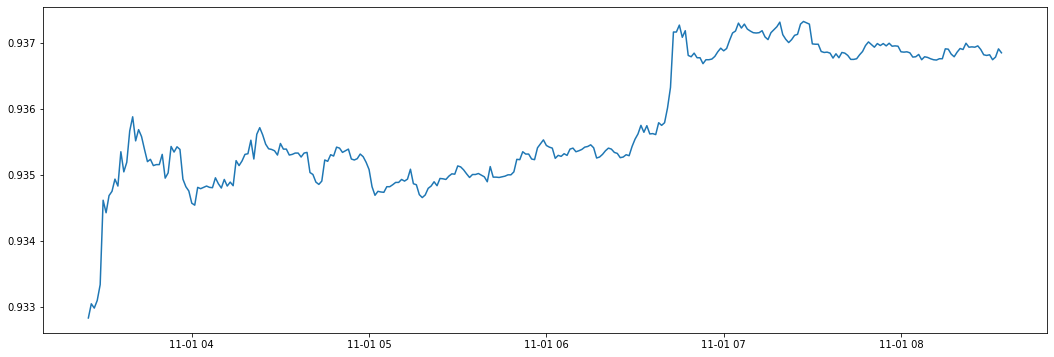

In [16]:
plt.figure(figsize=(18,6))
plt.plot(inp_data.iloc[190:SHIFT].close)

In [18]:
inp_data.iloc[190:SHIFT].head(40)

,open,high,low,close
time,,,,
2018-11-01 03:25:00,0.932770,0.933085,0.932755,0.932830
2018-11-01 03:26:00,0.932830,0.933130,0.932825,0.933045
2018-11-01 03:27:00,0.933045,0.933130,0.932905,0.932980
2018-11-01 03:28:00,0.932980,0.933100,0.932915,0.933095
2018-11-01 03:29:00,0.933095,0.933425,0.933090,0.933335
2018-11-01 03:30:00,0.933335,0.934685,0.933335,0.934615
2018-11-01 03:31:00,0.934615,0.934615,0.934175,0.934425
2018-11-01 03:32:00,0.934425,0.934705,0.934300,0.934685
2018-11-01 03:33:00,0.934685,0.934950,0.934575,0.934750


In [ ]:
plt.figure(figsize=(12,6))
plt.title('dropout')

plt.plot(df.TotalCash.cummax(), label='LocalMaximum', color='blue')
plt.plot(df.TotalCash.cummin(), label='LocalMinimum', color='red')

plt.legend(loc='lower right')
plt.show()

In [ ]:
# ret_df.groupby(by='Markdown').Profit.mean() / 100_000
pd.DataFrame(grid)

In [ ]:
create_grid(grid[1])

In [ ]:
df[df.HoldType != 'endPeriod']

In [ ]:
plt.step(x=df.index, y=df.Profit.cumsum())